<a href="https://colab.research.google.com/github/bhende27/Begali-Digit-Recognition-with-LeNet/blob/master/16MI31022_BDRW_LeNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os


In [2]:
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# import cv2

# image=[]
# count=0
# for i in range (0,1548):
#     fname= path + str(i)+ ".jpg"
#     if (os.path.exists(fname)):
#       img= cv2.imread(fname)
#       image.append(img)
#       count=count+1  
#  from google.colab.patches import cv2_imshow
#  cv2_imshow(image[11])      

##Spiltting of dataset into train test and validation

In [3]:
df=pd.read_excel("/content/drive/My Drive/data/BDRW_train_1/labels.xls",index_col=None, header= None)
train, validate, test = np.split(df.sample(frac=1), [int(.8*len(df)), int(.9*len(df))])

Looking for imbalanced class

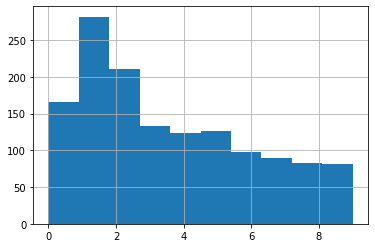

In [4]:
df[1].hist()

there are more sample consisting of 0, 1 2 and 3. Clearly data is not uniformly distributed

In [ ]:
# from keras.utils.np_utils import to_categorical
# Y = to_categorical(label['label'], num_classes = 10)

In [ ]:
#  R_image=[]
#  for i in range(0, 1393):
#    r_image = cv2.resize(image[i], (32, 32), interpolation=cv2.INTER_NEAREST)
#    R_image.append(r_image)
# imdata =np.vstack(R_image)
# imdata= imdata.reshape(-1,32,32, 3)
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(imdata, Y, test_size = 0.2, random_state =0)

In [5]:
%matplotlib inline
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from PIL import Image
import torch.optim as optim

In [6]:
class MyDataset():
    def __init__(self, df, root_dir, transform=None):
     
        self.label = df
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.label.iloc[idx, 0])
        img_name = img_name + ".jpg"
        image = Image.open(img_name)                  #from PIL Library
        labels = self.label.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)
            
        return image, labels

In [7]:
path= "/content/drive/My Drive/data/BDRW_train_1/"
BatchSize = 8
apply_transform = transforms.Compose([transforms.Resize((32,32)), transforms.Grayscale(num_output_channels=1), transforms.ToTensor()])

trainset = MyDataset( df = train, root_dir=path , transform=apply_transform)
trainLoader = DataLoader(trainset, batch_size=BatchSize, shuffle=True, num_workers=4)

validateset = MyDataset( df = validate, root_dir=path ,transform=apply_transform)
validateLoader = DataLoader(validateset, batch_size=BatchSize, shuffle=True, num_workers=4)

testset = MyDataset( df = test, root_dir=path ,transform=apply_transform)
testLoader = DataLoader(testset, batch_size=BatchSize, shuffle=True, num_workers=4)


In [8]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=2)        
        self.fc1 = nn.Linear(400, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 400)
        x = F.relu(self.fc1(x)) 
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x,dim=1)

In [9]:
use_gpu = torch.cuda.is_available()
net = LeNet()
print(net)
if use_gpu:
    print('GPU is avaialble!')
    net = net.cuda()

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


trainable parameter=  122304+5880+151600+2000+48120+10164=340068

In [10]:
criterion = nn.CrossEntropyLoss() 
learning_rate = 0.005
num_epochs = 30
optimizer = optim.SGD(net.parameters(),lr=learning_rate,momentum = 0.9)

train_loss = []
train_acc = []
validation_loss = []
validation_acc = []

for epoch in range(num_epochs):
    
    running_loss = 0.0 
    running_corr = 0
        
    for i,data in enumerate(trainLoader):
        inputs,labels = data
        if use_gpu:
            inputs, labels = inputs.cuda(),labels.cuda() 
        # Initializing model gradients to zero
        net.zero_grad() 
        # zero the paramenter gradients
        optimizer.zero_grad()
        # Data feed-forward through the network
        outputs = net(inputs)
        # Predicted class is the one with maximum probability
        preds = torch.argmax(outputs,dim=1)
        # Finding the loss
        loss = criterion(outputs, labels)
        # Accumulating the loss for each batch
        running_loss += loss 
        # Accumulate number of correct predictions
        running_corr += torch.sum(preds==labels)    
        # totalLoss = running_loss/(i+1)
        # Calculating gradients
        loss.backward()
        # Updating the model parameters
        optimizer.step()
        
    correct_pred1 = 0
    running_loss1 = 0.0
    i=0
    for data in validateLoader:
        inputs1,labels1 = data
        if use_gpu:
            inputs1, labels1 = inputs1.cuda(),labels1.cuda()
        # Feedforward train data batch through model
        outputs1 = net(inputs1) 
        # Predicted class is the one with maximum probability
        preds1 = torch.argmax(outputs1,dim=1)
        # Finding the loss
        loss1 = criterion(outputs1, labels1)
        # Accumulating the loss for each batch
        running_loss1 += loss1
        # Accumulate number of correct predictions
        correct_pred1 += torch.sum(preds1==labels1)
        i += 1

    val_loss = running_loss1.item()/(i+1)
    val_acc = correct_pred1.item()/len(validateset)

    epoch_loss = running_loss.item()/(i+1)   #Total loss for one epoch
    epoch_acc = running_corr.item()/len(trainset)

    validation_loss.append(val_loss) #Saving the loss over epochs for plotting the graph
    validation_acc.append(val_acc) #Saving the accuracy over epochs for plotting the graph
    train_loss.append(epoch_loss) #Saving the loss over epochs for plotting the graph
    train_acc.append(epoch_acc) #Saving the accuracy over epochs for plotting the graph
        
    print('Epoch {:.0f}/{:.0f} : Training loss: {:.4f} | Training Accuracy: {:.4f}| Validation Loss: {:.4f}| Validation Accuracy: {:.4f}'.format(epoch+1,num_epochs,epoch_loss,epoch_acc*100, val_loss, val_acc*100 ))

Epoch 1/30 : Training loss: 16.5938 | Training Accuracy: 17.8636| Validation Loss: 2.1427| Validation Accuracy: 17.9856
Epoch 2/30 : Training loss: 16.3419 | Training Accuracy: 20.6463| Validation Loss: 2.1181| Validation Accuracy: 17.9856
Epoch 3/30 : Training loss: 16.2764 | Training Accuracy: 20.9156| Validation Loss: 2.1120| Validation Accuracy: 17.9856
Epoch 4/30 : Training loss: 15.4544 | Training Accuracy: 26.5709| Validation Loss: 1.8450| Validation Accuracy: 26.6187
Epoch 5/30 : Training loss: 12.9165 | Training Accuracy: 38.7792| Validation Loss: 1.4212| Validation Accuracy: 50.3597
Epoch 6/30 : Training loss: 9.3769 | Training Accuracy: 59.1562| Validation Loss: 1.1432| Validation Accuracy: 58.2734
Epoch 7/30 : Training loss: 7.4060 | Training Accuracy: 67.1454| Validation Loss: 1.0668| Validation Accuracy: 66.9065
Epoch 8/30 : Training loss: 5.2622 | Training Accuracy: 77.4686| Validation Loss: 0.8161| Validation Accuracy: 76.9784
Epoch 9/30 : Training loss: 4.1314 | Traini

Text(0, 0.5, 'Validation')

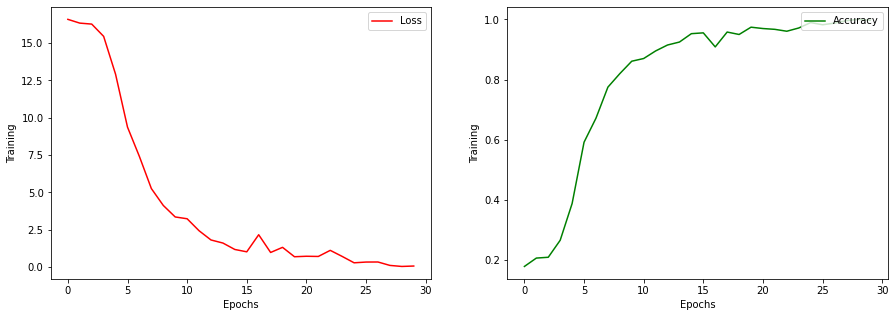

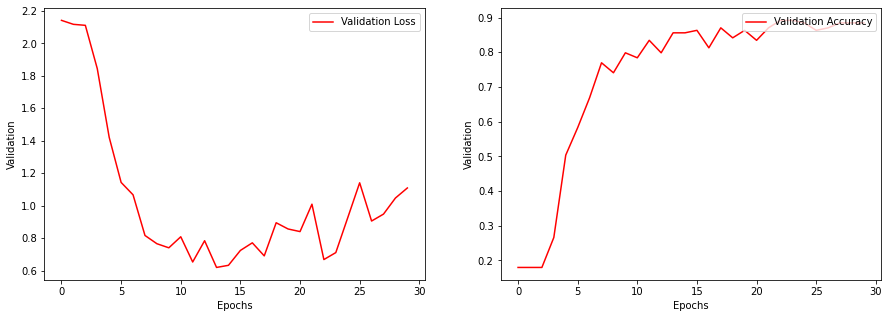

In [11]:
fig = plt.figure(figsize=[15,5]) 
plt.subplot(121)
plt.plot(range(num_epochs),train_loss,'r-',label='Loss') 
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Training')
plt.subplot(122)
plt.plot(range(num_epochs),train_acc,'g-',label='Accuracy') 
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Training')
fig = plt.figure(figsize=[15,5]) 
plt.subplot(121)
plt.plot(range(num_epochs),validation_loss,'r-',label='Validation Loss') 
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Validation')
plt.subplot(122)
plt.plot(range(num_epochs),validation_acc,'r-',label='Validation Accuracy') 
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Validation')\

In [12]:
correct_pred = 0
for data in testLoader:
    inputs,labels = data
    if use_gpu:
        inputs, labels = inputs.cuda(),labels.cuda()
    # Feedforward train data batch through model
    output = net(inputs) 
    # Predicted class is the one with maximum probability
    preds = torch.argmax(output,dim=1)
    correct_pred += torch.sum(preds==labels)

test_accuracy = correct_pred.item()/len(testset)
print('Testing accuracy = ',test_accuracy*100)

Testing accuracy =  86.42857142857143
